# Earnings Forecast using WRDS data

In [71]:
import wrds
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import seaborn as sns
from random import seed, sample
from tqdm.notebook import tqdm

In [2]:
conn = wrds.Connection(wrds_username='yzuskin')

Loading library list...
Done


### Step 1: Data Extraction from [WRDS](https://wrds-www.wharton.upenn.edu/)

|Source                        |Variable|Description                          |Alias   |
|------------------------------|--------|-------------------------------------|--------|
|Compustat - NA - Annual Update|gvkey   |Global Company Key                   |        |
|Merged Fundamental Annual File|fyear   |Data Year - Fiscal                   |        |
|Merged Fundamental Annual File|datadate|Data Date                            |date    |
|Merged Fundamental Annual File|ni      |Net Income (Loss)                    |earnings|
|Merged Fundamental Annual File|revt    |Revenue - Total                      |        |
|Merged Fundamental Annual File|at      |Assets - Total                       |        |
|Merged Fundamental Annual File|act     |Current Assets - Total               |        |
|Merged Fundamental Annual File|che     |Cash and Short-Term Investments      |        |
|Merged Fundamental Annual File|lct     |Current Liabilities - Total          |        |
|Merged Fundamental Annual File|dlc     |Debt in Current Liabilities - Total  |        |
|Merged Fundamental Annual File|txp     |Income Taxes Payable                 |        |
|Merged Fundamental Annual File|dp      |Depreciation and Amortization        |        |
|Merged Fundamental Annual File|dvt     |Dividends - Total                    |        |
|Merged Fundamental Annual File|mkvalt  |Market Value - Total - Fiscal        |        |
|Merged Fundamental Annual File|bkvlps  |Book Value Per Share                 |        |
|Merged Fundamental Annual File|csho    |Common Shares Outstanding            |        |
|Merged Fundamental Annual File|capx    |Capital Expenditures                 |        |
|Company Information File      |sic     |Standard Industry Classification Code|        |

In [8]:
funda=conn.raw_sql("""
                   select gvkey, fyear, datadate as date, ni as earnings, revt, at, act,
                   che, lct, dlc, txp, dp, dvt, mkvalt, bkvlps, csho, capx, tic
                   from compa.funda where
                        (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                        fyear<2018 and fyear>2008 and (exchg=11 or exchg=12)
                    """).dropna() # load compustat fundamentals annual table
company=conn.raw_sql("""
                     select gvkey, sic, conm, conml
                     from compa.company
                     """) # load company infomation table

In [10]:
funda.to_csv('final_funda.csv',index=False)
company.to_csv('final_company.csv',index=False)

In [9]:
funda.shape, company.shape

((12714, 18), (47261, 4))

### Step 2: Data Preprocessing

In [15]:
# load WRDS data offline from csv files
funda=pd.read_csv('final_funda.csv',parse_dates=['date'])
company=pd.read_csv('final_company.csv')

In [16]:
funda.shape, company.shape

((12714, 18), (47261, 4))

In [17]:
# merge the funda and company tables to add sic to funda
funda=pd.merge(funda,company,how='inner',on=['gvkey'])

In [18]:
# slice the sic variable to only include the first two digits
funda['sic']=funda['sic'].astype(str).str[:2].astype(int)
funda.rename(columns={'sic':'industry'},inplace=True)

In [19]:
# generate a temporary table of variables lagged one year back
temp=funda[['gvkey','fyear','act','che','lct','dlc','txp','earnings','capx']].copy()
temp['fyear']=temp['fyear']+1
temp=temp.rename(columns={'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1',
                          'txp':'txp_lag1','earnings':'earnings_lag1','capx':'capx_lag1'})
funda=pd.merge(funda,temp,how='left',on=['gvkey','fyear']).dropna()
# create change in current assets variable
funda['delta_act']=funda['act']-funda['act_lag1']
# create change in cash variable
funda['delta_che']=funda['che']-funda['che_lag1']
# create change in current liabilities variable
funda['delta_lct']=funda['lct']-funda['lct_lag1']
# create change in debt included in current liabilities variable
funda['delta_dlc']=funda['dlc']-funda['dlc_lag1']
# create change in income taxes payable variable
funda['delta_txp']=funda['txp']-funda['txp_lag1']
# create change in earnings variable
funda['delta_earnings']=funda['earnings']-funda['earnings_lag1']
# create change in capital expenditures variable
funda['delta_capx']=funda['capx']-funda['capx_lag1']
# dropped the lagged variables from the funda dataframe
funda.drop(columns=['act_lag1','che_lag1','lct_lag1',
                    'dlc_lag1','txp_lag1','capx_lag1'],inplace=True)
del temp # delete temporary table to reduce memory usage

In [20]:
# create book value variable that is not scaled by number of shares
funda['bkvalt']=funda['bkvlps']*funda['csho']

In [21]:
# create accrual component variable
funda['accrual']=((funda['delta_act']-funda['delta_che'])-
                  (funda['delta_lct']-funda['delta_dlc']-funda['delta_txp'])-
                  funda['dp'])
# create cash flow component variable
funda['cash_flow']=funda['earnings']-funda['accrual']

In [22]:
# dummy for negative earnings, accrual, and cash flow
funda['neg_earnings']=(funda['earnings']<0).replace({True:1,False:0})
funda['neg_accrual']=(funda['accrual']<0).replace({True:1,False:0})
funda['neg_cash_flow']=(funda['cash_flow']<0).replace({True:1,False:0})
# dummy for divinend payments
funda['dummy_div']=(funda['dvt']>0).replace({True:1,False:0})

In [23]:
temp=funda[['gvkey','fyear','earnings']].copy()
temp['fyear']=temp['fyear']-1
temp=temp.rename(columns={'earnings':'earnings_lead1'})
funda=pd.merge(funda,temp,how='left',on=['gvkey','fyear']).dropna()
del temp # delete temporary table to reduce memory usage

### Step 3: Exploratory Data Analysis

In [150]:
# define list of all independent and dependent variables
non_variables=['gvkey','fyear','date','conm','conml','csho','industry','tic']
variables=[v for v in funda.columns.to_list() if v not in non_variables]

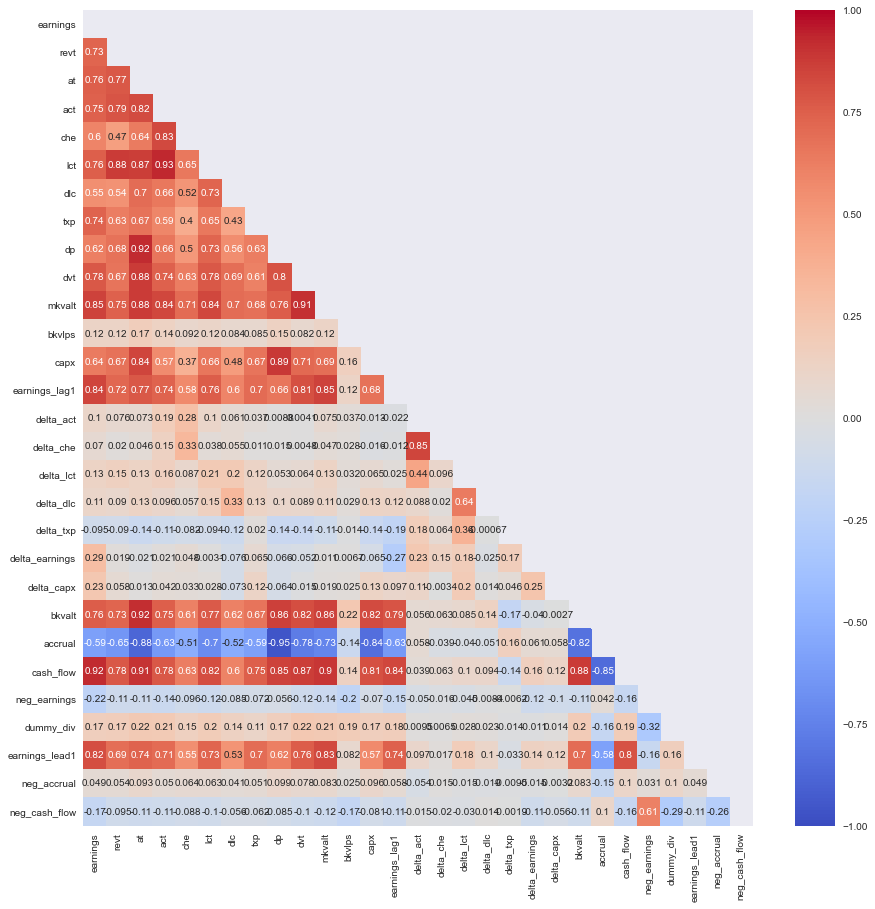

In [133]:
# plot correlation heatmap for all variables
plt.rcParams['figure.figsize']=[15,15]
sns.heatmap(funda[variables].corr(),annot=True,vmin=-1,vmax=1,
            center=0,cmap='coolwarm',mask=np.triu(funda[variables].corr()))
# for the purpose of identify good variables to predict earnings_lead1,
# the bottom row is the most important region of this plot, as it shows
# which variables are most strongly correlated with earnings_lead1

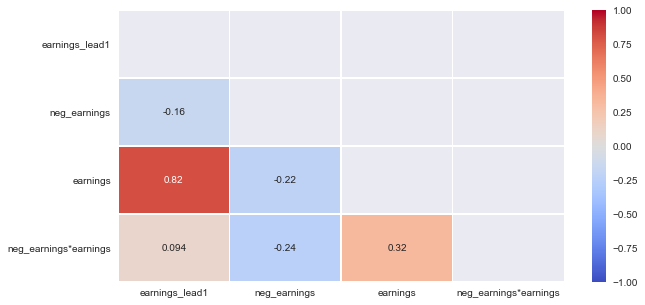

In [26]:
# plot correlation headmap of earnings persistence model variables
temp=funda.copy()
temp=temp[['earnings_lead1','neg_earnings','earnings']]
temp['neg_earnings*earnings']=temp.neg_earnings*temp.earnings
fig,ax=plt.subplots(figsize = (10,5))
ax=sns.heatmap(temp.corr(),annot=True,vmin=-1,vmax=1,center=0,
               cmap='coolwarm',mask=np.triu(temp.corr()),linewidths=.5)
del temp,fig,ax

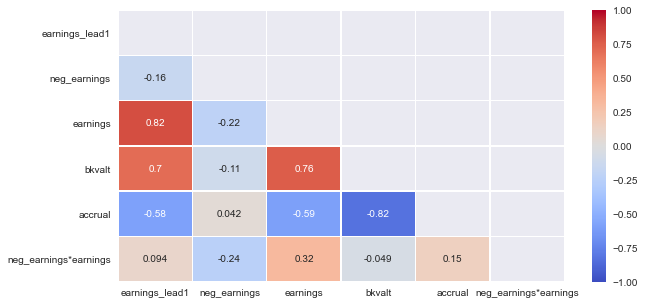

In [27]:
# plot correlation headmap of residual income model variables
temp=funda.copy()
temp=temp[['earnings_lead1','neg_earnings','earnings','bkvalt','accrual']]
temp['neg_earnings*earnings']=temp.neg_earnings*temp.earnings
fig,ax=plt.subplots(figsize = (10,5))
ax=sns.heatmap(temp.corr(),annot=True,vmin=-1,vmax=1,center=0,
               cmap='coolwarm',mask=np.triu(temp.corr()),linewidths=.5)
del temp,fig,ax

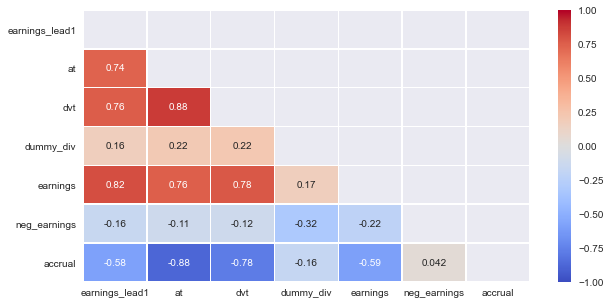

In [28]:
# plot correlation headmap of hvz income model variables
temp=funda.copy()
temp=temp[['earnings_lead1','at','dvt','dummy_div','earnings','neg_earnings','accrual']]
fig,ax= plt.subplots(figsize=(10,5))
ax=sns.heatmap(temp.corr(),annot=True,vmin=-1,vmax=1,center=0,
               cmap='coolwarm',mask=np.triu(temp.corr()),linewidths=.5)
del temp,fig,ax

### Step 4: Replicating Previously Developed Models

In [29]:
# baseline random walk model
ar=ols(formula='earnings_lead1 ~ earnings',data=funda[funda.fyear<2016]).fit()

In [30]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         earnings_lead1   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                 1.861e+04
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:52:31   Log-Likelihood:                -62378.
No. Observations:                7523   AIC:                         1.248e+05
Df Residuals:                    7521   BIC:                         1.248e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.4547     11.422      5.118      0.000      36.065      80.844
earnings       0.8341      0.006    136.412      0.000       0.822       0.846
==============================================================================
Omnibus:                     3456.150   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4779431.048
Skew:                          -0.588   Prob(JB):                         0.00
Kurtosis:                     126.475   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
ar_forecast=funda[funda.fyear==2016].copy()
ar_forecast['prediction']=ar.predict(ar_forecast)
ar_forecast['error']=ar_forecast['earnings_lead1']-ar_forecast['prediction']
ar_forecast['bias']=ar_forecast['error']/ar_forecast['mkvalt']

In [32]:
ar_forecast['bias'].mean(), abs(ar_forecast['bias']).mean()

(-0.2794316641140763, 0.4449306157804334)

In [33]:
# earnings persistence model
ep=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings',
       data=funda[funda.fyear<2016]).fit()

In [34]:
ep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         earnings_lead1   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     7297.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:52:53   Log-Likelihood:                -61932.
No. Observations:                7523   AIC:                         1.239e+05
Df Residuals:                    7519   BIC:                         1.239e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.1194     12.513      0.489      0.625     -18.410      30.649
neg_earnings            -60.9258     26.095     -2.335      0.020    -112.080      -9.772
earnings                  0.8911      0.006    145.071      0.000       0.879       0.903
neg_earnings:earnings    -0.6640      0.022    -30.610      0.000      -0.707      -0.621
==============================================================================
Omnibus:                     8288.326   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6920815.252
Skew:                          -4.775   Prob(JB):                         0.00
Kurtosis:                     151.283   Cond. No.                     4.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
ep_forecast=funda[funda.fyear==2016].copy()
ep_forecast['prediction']=ep.predict(ep_forecast)
ep_forecast['error']=ep_forecast['earnings_lead1']-ep_forecast['prediction']
ep_forecast['bias']=ep_forecast['error']/ep_forecast['mkvalt']

In [36]:
ep_forecast['bias'].mean(),abs(ep_forecast['bias']).mean()

(0.15296154012058913, 0.31907774593779725)

In [37]:
# residual income model
ri=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings + bkvalt + accrual',
      data=funda[funda.fyear<2016]).fit()

In [38]:
ri.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         earnings_lead1   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     4400.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:52:59   Log-Likelihood:                -61918.
No. Observations:                7523   AIC:                         1.238e+05
Df Residuals:                    7517   BIC:                         1.239e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                13.6303     12.609      1.081      0.280     -11.087      38.348
neg_earnings            -59.4461     26.059     -2.281      0.023    -110.529      -8.363
earnings                  0.9383      0.012     80.414      0.000       0.915       0.961
neg_earnings:earnings    -0.7337      0.025    -28.897      0.000      -0.783      -0.684
bkvalt                   -0.0060      0.003     -2.266      0.023      -0.011      -0.001
accrual                   0.0369      0.014      2.609      0.009       0.009       0.065
==============================================================================
Omnibus:                     7832.368   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6877645.746
Skew:                          -4.260   Prob(JB):                         0.00
Kurtosis:                     150.880   Cond. No.                     2.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
ri_forecast=funda[funda.fyear==2016].copy()
ri_forecast['prediction']=ri.predict(ri_forecast)
ri_forecast['error']=ri_forecast['earnings_lead1']-ri_forecast['prediction']
ri_forecast['bias']=ri_forecast['error']/ri_forecast['mkvalt']

In [40]:
ri_forecast['bias'].mean(), abs(ri_forecast['bias']).mean()

(0.10806527043631542, 0.29669413922545834)

In [41]:
# Hou, van Dijk and Zhang model
hvz=ols(formula='earnings_lead1 ~ at + dvt + dummy_div + earnings + neg_earnings + accrual',
        data=funda[funda.fyear<2016]).fit()

In [42]:
hvz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         earnings_lead1   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     3491.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:53:02   Log-Likelihood:                -62054.
No. Observations:                7523   AIC:                         1.241e+05
Df Residuals:                    7516   BIC:                         1.242e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -15.5893     20.039     -0.778      0.437     -54.872      23.694
at               0.0156      0.001     11.075      0.000       0.013       0.018
dvt              0.4795      0.033     14.699      0.000       0.416       0.543
dummy_div       -2.4037     23.498     -0.102      0.919     -48.467      43.660
earnings         0.6202      0.011     58.597      0.000       0.599       0.641
neg_earnings    47.1383     27.552      1.711      0.087      -6.871     101.148
accrual          0.2124      0.018     11.986      0.000       0.178       0.247
==============================================================================
Omnibus:                     6169.945   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5911172.529
Skew:                          -2.669   Prob(JB):                         0.00
Kurtosis:                     140.220   Cond. No.                     7.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
hvz_forecast=funda[funda.fyear==2016].copy()
hvz_forecast['prediction']=hvz.predict(hvz_forecast)
hvz_forecast['error']=hvz_forecast['earnings_lead1']-hvz_forecast['prediction']
hvz_forecast['bias']=hvz_forecast['error']/hvz_forecast['mkvalt']

In [44]:
hvz_forecast['bias'].mean(), abs(hvz_forecast['bias']).mean()

(-0.09164820284881797, 0.28907436562045374)

### Step 5: Development of Improved Model

In [119]:
# improved Hou, van Dijk and Zhang model
ihvz=ols(formula='earnings_lead1~at+dvt+earnings+accrual+delta_earnings-1',
         data=funda[funda.fyear<2016]).fit()

In [121]:
ihvz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         earnings_lead1   R-squared (uncentered):                   0.757
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              3908.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):                        0.00
Time:                        17:15:24   Log-Likelihood:                         -61924.
No. Observations:                7523   AIC:                                  1.239e+05
Df Residuals:                    7517   BIC:                                  1.239e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
at                 0.0101      0.001      7.384      0.000       0.007       0.013
dvt                0.4801      0.034     14.213      0.000       0.414       0.546
earnings           0.6479      0.013     51.823      0.000       0.623       0.672
accrual            0.1642      0.017      9.393      0.000       0.130       0.198
delta_earnings    -0.0810      0.014     -5.878      0.000      -0.108      -0.054
delta_lct          0.2446      0.015     16.153      0.000       0.215       0.274
==============================================================================
Omnibus:                     6495.918   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5626976.174
Skew:                          -2.974   Prob(JB):                         0.00
Kurtosis:                     136.850   Cond. No.                         80.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
ihvz_forecast=funda[funda.fyear==2016].copy()
ihvz_forecast['prediction']=ihvz.predict(ihvz_forecast)
ihvz_forecast['error']=ihvz_forecast['earnings_lead1']-ihvz_forecast['prediction']
ihvz_forecast['bias']=ihvz_forecast['error']/ihvz_forecast['mkvalt']

In [122]:
ihvz_forecast['bias'].mean(), abs(ihvz_forecast['bias']).mean()

(0.03183883754869807, 0.20286449760223607)

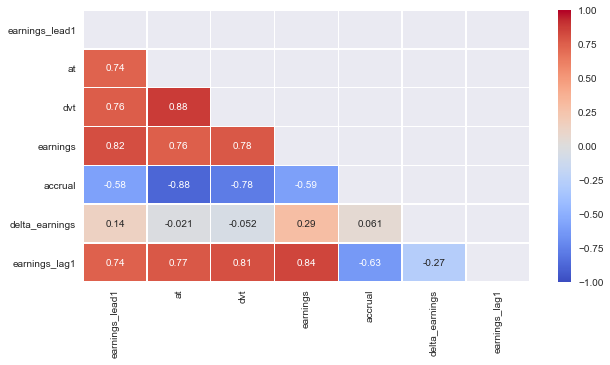

In [125]:
# plot correlation headmap of improved Hou, van Dijk and Zhang income model variables
temp=funda.copy()
temp=temp[['earnings_lead1','at','dvt','earnings','accrual','delta_earnings','earnings_lag1']]
fig,ax=plt.subplots(figsize = (10,5))
ax=sns.heatmap(temp.corr(),annot=True,vmin=-1,vmax=1,center=0,
               cmap='coolwarm',mask=np.triu(temp.corr()),linewidths=.5)
del temp,fig,ax

### Step 6: Evaluating Improved Model on Subset of 10 Corporations

In [100]:
seed(12) # randomly select a subset of 10 corporations
selection=sample(list(set(funda.tic.to_list())),10)

In [103]:
selection

['LLEX', 'TGNA', 'HXL', 'TWX', 'FNV', 'NLS', 'EGI', 'TEN', 'CTEK', 'MAN']

In [106]:
subset=funda[funda.tic.isin(selection) & funda.fyear.eq(2016)].copy()
subset['prediction']=ihvz.predict(subset)
subset['error']=subset['earnings_lead1']-subset['prediction']
subset['bias']=subset['error']/subset['mkvalt']

C:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\tf_gpu_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [107]:
subset['bias'].mean(), abs(subset['bias']).mean()

(-0.12091512081402027, 0.13301267060213476)

In [112]:
subset[['tic','industry','bias']]

,tic,industry,bias
1436,TGNA,48,-0.032599
1667,HXL,28,0.018695
3353,TEN,37,-0.016189
4355,MAN,73,0.020697
5586,TWX,48,0.013302
5853,NLS,39,0.003722
6953,EGI,10,-0.022280
7562,CTEK,73,-0.221307
9693,FNV,67,0.004072
10283,LLEX,13,-0.977263


### Step 7: Model Selection Rolling Table (By Industry)

In [13]:
# Drop the records that the response variable is missing
funda2=funda.dropna(subset=['earnings_lead1'])

In [14]:
# A list of all unique industry code in funda2
funda2['industry'].unique()

array([50, 36, 49, 28, 34, 51, 38, 63, 10, 45, 44, 99, 37, 13, 73, 20, 27,
       80, 35, 29, 26, 87, 48, 57, 72, 79, 39, 31, 33, 16, 40, 56, 58, 64,
       42, 30, 22, 53, 82, 67, 25, 70, 52, 17, 62, 54, 23, 24, 78, 65, 59,
       12, 32, 55, 15, 21, 75, 14, 46, 83, 47, 60], dtype=int64)

In [32]:
# Create Model Selection Rolling Table
j=0
df_MAE=pd.DataFrame(funda2['industry'].unique()).rename(columns={0:'Industry'})
MAE_ar_lst=[0]*len(df_MAE)
MAE_ep_lst=[0]*len(df_MAE)
MAE_ri_lst=[0]*len(df_MAE)
MAE_hvz_lst=[0]*len(df_MAE)
MAE_ihvz_lst=[0]*len(df_MAE)

for i in funda2['industry'].unique():
    funda_temp=funda2[funda2['industry']==i]
    # run ar
    ar=ols(formula='earnings_lead1 ~ earnings',data=funda_temp[funda_temp.fyear<2016]).fit()
    ar_forecast=funda_temp[funda_temp.fyear==2016]
    ar_forecast=ar_forecast[['gvkey','fyear','earnings','earnings_lead1','mkvalt']]
    ar_forecast['prediction']=ar.predict(ar_forecast)
    ar_forecast['error']=ar_forecast['earnings_lead1']-ar_forecast['prediction']
    ar_forecast['bias']=ar_forecast['error']/ar_forecast['mkvalt']
    MAE_ar=abs(ar_forecast['bias']).mean()
    MAE_ar_lst[j]=MAE_ar
    # run ep
    ep=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings',data=funda_temp[funda_temp.fyear<2016]).fit()
    ep_forecast=funda_temp[funda_temp.fyear==2016]
    ep_forecast=ep_forecast[['gvkey','fyear','earnings','neg_earnings','earnings_lead1','mkvalt']]
    ep_forecast['prediction']=ep.predict(ep_forecast)
    ep_forecast['error']=ep_forecast['earnings_lead1']-ep_forecast['prediction']
    ep_forecast['bias']=ep_forecast['error']/ep_forecast['mkvalt']
    MAE_ep=abs(ep_forecast['bias']).mean()
    MAE_ep_lst[j]=MAE_ep
    # run ri
    ri=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings + bkvl + accrual',data=funda_temp[funda_temp.fyear<2016]).fit()
    ri_forecast=funda_temp[funda_temp.fyear==2016]
    ri_forecast=ri_forecast[['gvkey','fyear','earnings','neg_earnings','bkvl','accrual','earnings_lead1','mkvalt']]
    ri_forecast['prediction']=ri.predict(ri_forecast)
    ri_forecast['error']=ri_forecast['earnings_lead1']-ri_forecast['prediction']
    ri_forecast['bias']=ri_forecast['error']/ri_forecast['mkvalt']
    MAE_ri=abs(ri_forecast['bias']).mean()
    MAE_ri_lst[j]=MAE_ri
    # run hvz
    hvz=ols(formula='earnings_lead1 ~ at + dvt + dummy_div + earnings + neg_earnings + accrual',
        data=funda_temp[funda_temp.fyear<2016]).fit()
    hvz_forecast=funda_temp[funda_temp.fyear==2016]
    hvz_forecast=hvz_forecast[['gvkey','fyear','earnings','neg_earnings','dummy_div','at','dvt','accrual','earnings_lead1','mkvalt']]
    hvz_forecast['prediction']=hvz.predict(hvz_forecast)
    hvz_forecast['error']=hvz_forecast['earnings_lead1']-hvz_forecast['prediction']
    hvz_forecast['bias']=hvz_forecast['error']/hvz_forecast['mkvalt']
    MAE_hvz=abs(hvz_forecast['bias']).mean()
    MAE_hvz_lst[j]=MAE_hvz
    
    # run ihvz
    ihvz=ols(formula='earnings_lead1 ~ at + dvt + earnings + accrual + delta_earnings - 1',
         data=funda_temp[funda_temp.fyear<2016]).fit()
    ihvz_forecast=funda_temp[funda_temp.fyear==2016]
    ihvz_forecast=ihvz_forecast[['gvkey','fyear','earnings','neg_earnings','dummy_div','at','dvt','accrual','earnings_lead1','mkvalt','delta_earnings']]
    ihvz_forecast['prediction']=ihvz.predict(ihvz_forecast)
    ihvz_forecast['error']=ihvz_forecast['earnings_lead1']-ihvz_forecast['prediction']
    ihvz_forecast['bias']=ihvz_forecast['error']/ihvz_forecast['mkvalt']
    MAE_ihvz=abs(ihvz_forecast['bias']).mean()
    MAE_ihvz_lst[j]=MAE_ihvz

    j=j+1
    print('Industry=%d :'%i + 'MAE_ar=%s'%MAE_ar + ', MAE_ep=%s'%MAE_ep + ', MAE_ri=%s'%MAE_ri + ', MAE_hvz=%s'% MAE_hvz+ ', MAE_ihvz=%s'% MAE_ihvz)

Industry=50 :MAE_ar=0.12894701974014763, MAE_ep=0.05876639810466767, MAE_ri=0.060432448030047325, MAE_hvz=0.10700207813026875, MAE_ihvz=0.03712108452222783
Industry=36 :MAE_ar=0.5231447877442054, MAE_ep=0.20414048882934452, MAE_ri=0.25481327236062346, MAE_hvz=0.2885841622692196, MAE_ihvz=0.11599574064992949
Industry=49 :MAE_ar=0.2100807434823752, MAE_ep=0.20043906445580362, MAE_ri=0.11177233872263787, MAE_hvz=0.15009780632613276, MAE_ihvz=0.05196054223415273
Industry=28 :MAE_ar=0.7988717251865062, MAE_ep=0.371094714007576, MAE_ri=0.39440685344363735, MAE_hvz=0.36677374756273284, MAE_ihvz=0.18982914246844831
Industry=34 :MAE_ar=0.09184768616722393, MAE_ep=0.046808665636493364, MAE_ri=0.03647974938788491, MAE_hvz=0.03017833552219387, MAE_ihvz=0.02773149220824084
Industry=51 :MAE_ar=0.15162684812007649, MAE_ep=0.2477590976957225, MAE_ri=0.24481465712320277, MAE_hvz=0.24387281820014609, MAE_ihvz=0.11684570675299175
Industry=38 :MAE_ar=0.7017263471424903, MAE_ep=0.3401859341297778, MAE_ri=0

In [33]:
# Concatenate all the subtable
df_MAE=pd.concat([df_MAE,pd.DataFrame(MAE_ar_lst).rename(columns={0:'ar'}),pd.DataFrame(MAE_ep_lst).rename(columns={0:'ep'}),pd.DataFrame(MAE_ri_lst).rename(columns={0:'ri'}),pd.DataFrame(MAE_hvz_lst).rename(columns={0:'hvz'}),pd.DataFrame(MAE_ihvz_lst).rename(columns={0:'ihvz'})],axis=1)

In [34]:
# Based on the value of bias, give a selection to each industry
df_MAE['Select']=df_MAE[['ar','ep','ri','hvz','ihvz']].idxmin(axis=1)

In [35]:
# give the variables a proper name
df_MAE=df_MAE.rename(columns={'ar':'bias_ar','ep':'bias_ep','ri':'bias_ri','hvz':'bias_hvz','ihvz':'bias_ihvz'})

In [36]:
# A frequency Table
df_MAE['Select'].value_counts()


ihvz    29
ar      11
hvz      8
ri       8
ep       6
Name: Select, dtype: int64

##### It shows that 29 industries choice ihvz as best model
##### 11 industries choice ar as best model
##### 8 industries choice hvz as best model
##### 8 industries choice ri as best model
##### 6 industries choice ep as best model

In [37]:
# the result of the Model Selection Rolling Table
df_MAE

,Industry,bias_ar,bias_ep,bias_ri,bias_hvz,bias_ihvz,Select
0,50,0.128947,0.058766,0.060432,0.107002,0.037121,ihvz
1,36,0.523145,0.204140,0.254813,0.288584,0.115996,ihvz
2,49,0.210081,0.200439,0.111772,0.150098,0.051961,ihvz
3,28,0.798872,0.371095,0.394407,0.366774,0.189829,ihvz
4,34,0.091848,0.046809,0.036480,0.030178,0.027731,ihvz
5,51,0.151627,0.247759,0.244815,0.243873,0.116846,ihvz
6,38,0.701726,0.340186,0.318813,0.744997,0.045708,ihvz
7,63,0.014751,0.014751,0.042881,0.096260,0.017913,ar
8,10,0.394303,0.661097,0.246020,0.330735,0.103657,ihvz
9,45,0.172449,0.163137,0.140645,0.661971,0.076156,ihvz


### Step 8: Earning Prediction Rolling Table (By Industry)

In [51]:
funda3=conn.raw_sql("""
                   select gvkey, fyear, datadate as date, ni as earnings, revt, at, act,
                   che, lct, dlc, txp, dp, dvt, mkvalt, bkvlps, csho, capx, tic
                   from compa.funda where
                        (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
                        fyear<2020 and fyear>2008 and (exchg=11 or exchg=12)
                    """).dropna() # load compustat fundamentals annual table

In [64]:
company['gvkey']=company['gvkey'].astype(str)

In [65]:
funda3=pd.merge(funda3,company,how='inner',on=['gvkey'])

In [66]:
# generate a temporary table of variables lagged one year back
temp=funda3[['gvkey','fyear','act','che','lct','dlc','txp','earnings','capx']].copy()
temp['fyear']=temp['fyear']+1
temp=temp.rename(columns={'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1',
                          'txp':'txp_lag1','earnings':'earnings_lag1','capx':'capx_lag1'})
funda3=pd.merge(funda3,temp,how='left',on=['gvkey','fyear']).dropna()
# create change in current assets variable
funda3['delta_act']=funda3['act']-funda3['act_lag1']
# create change in cash variable
funda3['delta_che']=funda3['che']-funda3['che_lag1']
# create change in current liabilities variable
funda3['delta_lct']=funda3['lct']-funda3['lct_lag1']
# create change in debt included in current liabilities variable
funda3['delta_dlc']=funda3['dlc']-funda3['dlc_lag1']
# create change in income taxes payable variable
funda3['delta_txp']=funda3['txp']-funda3['txp_lag1']
# create change in earnings variable
funda3['delta_earnings']=funda3['earnings']-funda3['earnings_lag1']
# create change in capital expenditures variable
funda3['delta_capx']=funda3['capx']-funda3['capx_lag1']
# dropped the lagged variables from the funda dataframe
funda3.drop(columns=['act_lag1','che_lag1','lct_lag1',
                    'dlc_lag1','txp_lag1','capx_lag1'],inplace=True)
del temp # delete temporary table to reduce memory usage

In [67]:
# create book value variable that is not scaled by number of shares
funda3['bkvalt']=funda3['bkvlps']*funda3['csho']
# create accrual component variable
funda3['accrual']=((funda3['delta_act']-funda3['delta_che'])-
                  (funda3['delta_lct']-funda3['delta_dlc']-funda3['delta_txp'])-
                  funda3['dp'])
# create cash flow component variable
funda3['cash_flow']=funda3['earnings']-funda3['accrual']
# dummy for negative earnings
funda3['neg_earnings']=(funda3['earnings']<0).replace({True:1,False:0})
# dummy for divinend payments
funda3['dummy_div']=(funda3['dvt']>0).replace({True:1,False:0})

In [68]:
# In order to predict earning in 2019, select the data in 2018
funda_2018=funda3[funda3['fyear']==2018]

In [71]:
funda_2018['sic']=funda_2018['sic'].astype(str).str[:2].astype(int)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
funda_2018.rename(columns={'sic':'industry'},inplace=True)

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [78]:
funda_2018['industry']=funda_2018['industry'].astype(str)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
df_MAE['Industry']=df_MAE['Industry'].astype(str)

In [85]:
df_MAE=df_MAE.rename(columns={'Industry':'industry'})

In [288]:
funda_2018=funda_2018.rename(columns={'bkvalt':'bkvl'})

In [130]:
funda2['industry']=funda2['industry'].astype(str)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [147]:
# reset the index
funda_2018=funda_2018.reset_index(drop=True)

In [290]:
# make prediction for earning in 2019 based on the best model we found in model selection rolling table
i=0
pred_2019=['na']*len(funda_2018)
lst=[0]*len(funda_2018)
while i < len(funda_2018):

    if funda_2018.iloc[i,18] in list(df_MAE.industry):
        for j in df_MAE.industry:
            if j==funda_2018.iloc[i,18]:
                funda_temp=funda2[funda2['industry']==j]
                if (df_MAE[df_MAE['industry']==j]['Select']=='ar').bool():
                    ar=ols(formula='earnings_lead1 ~ earnings',data=funda_temp[funda_temp.fyear<2016]).fit()
                    pred_2019[i]=(ar.predict(funda_2018.iloc[[i],:])).values
                    lst[i]='ar'
                    
                if (df_MAE[df_MAE['industry']==j]['Select']=='ep').bool():
                    ep=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings'
                           ,data=funda_temp[funda_temp.fyear<2016]).fit()
                    pred_2019[i]=(ep.predict(funda_2018.iloc[[i],:])).values
                    lst[i]='ep'
                    
                if (df_MAE[df_MAE['industry']==j]['Select']=='ri').bool():
                    ri=ols(formula='earnings_lead1 ~ neg_earnings + earnings + neg_earnings*earnings + bkvl + accrual'
                           ,data=funda_temp[funda_temp.fyear<2016]).fit()
                    pred_2019[i]=(ri.predict(funda_2018.iloc[[i],:])).values
                    lst[i]='ri'
                    
                if (df_MAE[df_MAE['industry']==j]['Select']=='hvz').bool():
                    hvz=ols(formula='earnings_lead1 ~ at + dvt + dummy_div + earnings + neg_earnings + accrual',
                            data=funda_temp[funda_temp.fyear<2016]).fit()
                    pred_2019[i]=(hvz.predict(funda_2018.iloc[[i],:])).values
                    lst[i]='hvz'
                    
                if (df_MAE[df_MAE['industry']==j]['Select']=='ihvz').bool():
                    ihvz=ols(formula='earnings_lead1 ~ at + dvt + earnings + accrual + delta_earnings - 1',
                             data=funda_temp[funda_temp.fyear<2016]).fit()
                    pred_2019[i]=(ihvz.predict(funda_2018.iloc[[i],:])).values
                    lst[i]='ihvz'
                    
    # if there is a new industry that is not in the previous table, 
    # I use the aggregated ihvz to make a prediction, cuz it's the best model at aggregate level
    if funda_2018.iloc[i,18] not in list(df_MAE.industry):
        ihvz=ols(formula='earnings_lead1 ~ at + dvt + earnings + accrual + delta_earnings - 1',
                 data=funda[funda.fyear<2016]).fit()
        pred_2019[i]=(ihvz.predict(funda_2018.iloc[[i],:])).values
        lst[i]='ihvz'
    i=i+1
    
    

In [291]:
# concatenate the table with rename variables
industry_rolling=pd.concat([funda_2018[['gvkey','industry','fyear','earnings']],pd.DataFrame(lst).rename(columns={0:'model_selected'}),pd.DataFrame(pred_2019).rename(columns={0:'Pred_earning_2019'})],axis=1)

In [294]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [292]:
# the result of the Earning Prediction Rolling Table (By Industry)
industry_rolling

,gvkey,industry,fyear,earnings,model_selected,Pred_earning_2019
0,1121,51,2018.0,511.047,ihvz,729.793940
1,1209,28,2018.0,2368.000,ihvz,4271.367571
2,1209,28,2018.0,2368.000,ihvz,4451.956742
3,1209,28,2018.0,4.598,ihvz,-174.246901
4,1209,28,2018.0,4.598,ihvz,6.342271
5,1230,45,2018.0,-0.195,ihvz,-7.194534
6,1230,45,2018.0,-0.195,ihvz,-1.510480
7,1380,13,2018.0,-326.701,ihvz,-570.551356
8,1380,13,2018.0,1497.800,ihvz,849.078242
9,1410,73,2018.0,437.000,ihvz,729.638441


In [295]:
len(intersection(funda_2018['industry'].unique(),df_MAE['industry'].values))

55

In [311]:
# check if there are new industry in 2018
set(list(funda_2018['industry'].unique())) <= set(list(df_MAE['industry'].unique()))

True